In [73]:
import pymatching
import sinter
from typing import *
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    num_detectors = circuit.num_detectors
    num_observables = circuit.num_observables

    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Extract decoder configuration data from the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)

    # Run the decoder.
    predictions = sinter.predict_observables(
        dem=detector_error_model,
        dets=detection_events,
        decoder='pymatching',
    )

    # Count the mistakes.
    num_errors = 0
    for actual_flip, predicted_flip in zip(observable_flips, predictions):
        if not np.array_equal(actual_flip, predicted_flip):
            num_errors += 1
    return num_errors


def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

print line_intersection((A, B), (C, D))


The two cells below produce a graphs to show how the probability of success changes as the error probability increases for the distance 2 repetition code and the distance 3 surface code.

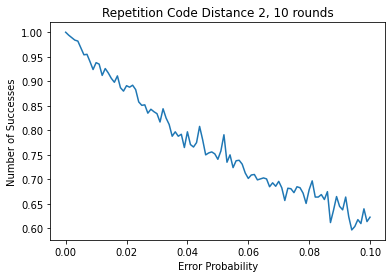

In [74]:
#This code generates a plot of the probability of success versus the error probability for
#a repetition code with a fixed distance and number of rounds.


distance = 2
rounds = 10
num_shots = 1000
success_rate = []

error_probs = np.arange(0, 0.101, 0.001)

for p in error_probs:
    circuit = stim.Circuit.generated("repetition_code:memory", rounds=rounds, distance=distance, before_round_data_depolarization=p)
    num_logical_errors = count_logical_errors(circuit, num_shots)
    num_successes = num_shots - num_logical_errors
    success_rate.append(num_successes/float(num_shots))

plt.plot(error_probs, success_rate)
plt.xlabel('Error Probability')
plt.ylabel('Number of Successes')
plt.title(f'Repetition Code Distance {distance}, {rounds} rounds')
plt.show()

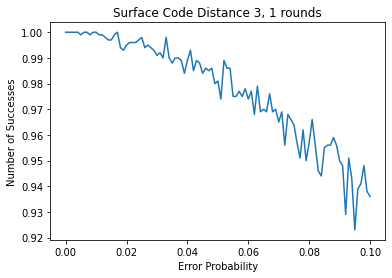

In [76]:
#This code generates a plot of the probability of success versus the error probability for
#a surface code with a fixed distance and number of rounds.

distance = 3
rounds = 10
num_shots = 1000
success_rate = []

error_probs = np.arange(0, 0.101, 0.001)

for p in error_probs:
    circuit = stim.Circuit.generated("surface_code:rotated_memory_z", rounds=rounds, distance=distance, before_round_data_depolarization=p)
    num_logical_errors = count_logical_errors(circuit, num_shots)
    num_successes = num_shots - num_logical_errors
    success_rate.append(num_successes/float(num_shots))

plt.plot(error_probs, success_rate)
plt.xlabel('Error Probability')
plt.ylabel('Number of Successes')
plt.title(f'Surface Code Distance {distance}, {rounds} rounds')
plt.show()


The cells below plot the probability of success against increasing number of rounds with a fixed probability for the distance 3 surface code and the distance 2 repetition code.

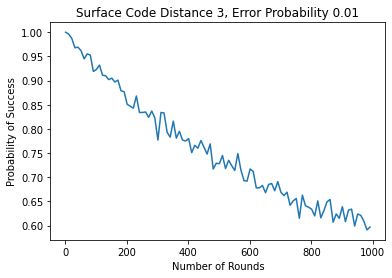

In [92]:
import matplotlib.pyplot as plt

#This code generates a plot of the probability of success versus 
#the number of rounds for a surface code with a fixed distance and error probability.

distance = 3
num_shots = 1000
success_rate = []

rounds_range = range(1, 1001, 10)

error_prob = 0.01

for r in rounds_range:
    circuit = stim.Circuit.generated("surface_code:rotated_memory_z", rounds=r, distance=distance, before_round_data_depolarization=error_prob)
    num_logical_errors = count_logical_errors(circuit, num_shots)
    num_successes = num_shots - num_logical_errors
    success_rate.append(num_successes/float(num_shots))

plt.plot(rounds_range, success_rate)
plt.xlabel('Number of Rounds')
plt.ylabel('Probability of Success')
plt.title(f'Surface Code Distance {distance}, Error Probability {error_prob}')
plt.show()


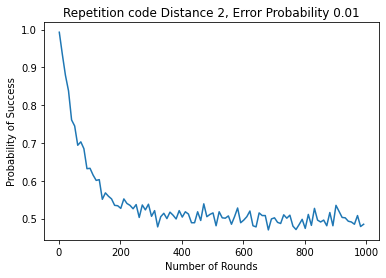

In [93]:
import matplotlib.pyplot as plt

#This code generates a plot of the probability of success versus
#the number of rounds for a surface code with a fixed distance and error probability.

distance = 2
num_shots = 1000
success_rate = []

rounds_range = range(1, 1001, 10)


error_prob = 0.01

for r in rounds_range:
    circuit = stim.Circuit.generated("repetition_code:memory", rounds=r, distance=distance, before_round_data_depolarization=error_prob)
    num_logical_errors = count_logical_errors(circuit, num_shots)
    num_successes = num_shots - num_logical_errors
    success_rate.append(num_successes/float(num_shots))

plt.plot(rounds_range, success_rate)
plt.xlabel('Number of Rounds')
plt.ylabel('Probability of Success')
plt.title(f'Repetition code Distance {distance}, Error Probability {error_prob}')
plt.show()


## Calculating the threshold 

[-0.00388425  0.03599411  0.10239515  0.19477776  0.29568028  0.38051724
  0.43751492  0.47027464  0.48743708  0.49599307]
{-0.0, 0.1, 0.3, 0.19, 0.38, 0.44, 0.47, 0.49, 0.5, 0.04}
[-0.0048782   0.00966219  0.04290057  0.1098214   0.2156979   0.33273518
  0.4203456   0.46868009  0.4909599   0.50037536]
{-0.0, 0.11, 0.22, 0.33, 0.42, 0.47, 0.49, 0.5, 0.01, 0.04}
[-0.00407476  0.00136167  0.01655593  0.05598552  0.14126208  0.2700309
  0.38767954  0.45501271  0.48374296  0.49444344]
{-0.0, 0.14, 0.27, 0.06, 0.39, 0.46, 0.48, 0.49, 0.02}


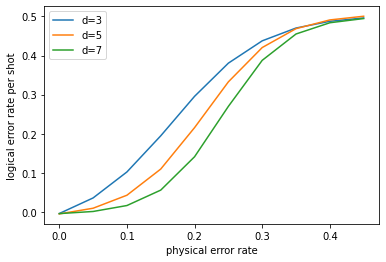

set()


In [160]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

error_probs = np.arange(0,0.5,0.05)

x_and_y_sets = []


num_shots = 10_000
for d in [3, 5, 7]:
    x_and_y_set = set()
    x_and_y_sets.append(x_and_y_set)
    xs = []
    ys = []
    for noise in error_probs:
        circuit = stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise)
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        x = noise
        y = num_errors_sampled / num_shots
        xs.append(x)
        ys.append(y)
        
    
        
    p0 = [max(ys), np.median(xs),1,min(ys)] # this is an mandatory initial guess
    
    popt, pcov = curve_fit(sigmoid, xs, ys,p0, method='dogbox')
    fit_y = sigmoid(xs, *popt)
    print(fit_y)
    plt.plot(xs, fit_y ,'-', label="d=" + str(d))
    x_and_y_set = set([round(y,2) for y in fit_y])
    print(x_and_y_set)
    x_and_y_sets.append(x_and_y_set)
#     plt.plot(xs, ys, 'o', label="d=" + str(d))


plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()

x_and_y_same = x_and_y_sets[0].intersection(x_and_y_sets[1]).intersection(x_and_y_sets[2])

print(x_and_y_same)


[0.0, 0.1341, 0.3486, 0.4547, 0.4927, 0.5038, 0.4982, 0.5039, 0.5, 0.5016]
Optimal parameters not found for d= 3
[0.0, 0.1162, 0.4029, 0.4944, 0.4961, 0.4929, 0.5038, 0.5007, 0.4978, 0.5086]
[0.0, 0.0775, 0.4156, 0.4941, 0.5091, 0.5026, 0.4988, 0.5024, 0.4908, 0.4989]
Optimal parameters not found for d= 7


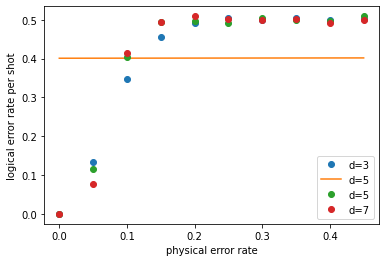

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import stim

def sigmoid(x, L, x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return y

error_probs = np.arange(0, 0.5, 0.05)
num_shots = 10_000
x_and_y_sets = []

for d in [3, 5, 7]:
    xs = []
    ys = []
    for noise in error_probs:
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise)
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        x = noise
        y = num_errors_sampled / num_shots
        xs.append(x)
        ys.append(y)
    
    print(ys)
    p0 = [max(ys), np.median(xs), 1, min(ys)] # this is a mandatory initial guess
    
    try:
        popt, pcov = curve_fit(sigmoid, xs, ys, p0=p0, method='dogbox', maxfev=10000)
        fit_y = sigmoid(xs, *popt)
        plt.plot(xs, fit_y, '-', label="d=" + str(d))
    except RuntimeError:
        print("Optimal parameters not found for d=", d)

    plt.plot(xs, ys, 'o', label="d=" + str(d))
    
    
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()
